In [141]:
import io
import pandas as pd
import numpy as np
import scipy as sci

from sklearn.preprocessing import MinMaxScaler # found in the scikit-learn package
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import SGD
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [142]:
path_g = "green-thai-curry-sales.csv"
df_g = pd.read_csv(path_g)
path_v = "vegetable-korma-curry-sales.csv"
df_v = pd.read_csv(path_v)

In [143]:
df_g.head()

,Date,Sales
0,1/1/2011,366
1,1/2/2011,301
2,1/3/2011,309
3,1/4/2011,263
4,1/5/2011,279


In [144]:
df_v.head()

,Date,Sales
0,1/1/2011,208
1,1/2/2011,240
2,1/3/2011,206
3,1/4/2011,190
4,1/5/2011,228


In [145]:
df_g = df_g['Sales']
df_v = df_v['Sales']

In [146]:
df = df_g + df_v

In [147]:
df.head()

0    574
1    541
2    515
3    453
4    507
Name: Sales, dtype: int64

In [148]:
df.index = df.index + 1

data = pd.concat([df.shift(1), df.shift(2), df.shift(3), df], axis=1)
data.columns = ['x1','x2', 'x3', 'y']
data = data.iloc[4:,]
data.head()

,x1,x2,x3,y
5,453.0,515.0,541.0,507
6,507.0,453.0,515.0,561
7,561.0,507.0,453.0,499
8,499.0,561.0,507.0,544
9,544.0,499.0,561.0,601


In [149]:
train = data[:int(data.shape[0]*0.8)]
test = data[int(data.shape[0]*0.8):]

data = data.dropna()
train = train.dropna()
test = test.dropna()

In [150]:
ytrain_min = float(train.min()['y'])
ytrain_max = float(train.max()['y'])
ytrain_range = ytrain_max - ytrain_min

ytest_min = float(test.min()['y'])
ytest_max = float(test.max()['y'])
ytest_range = ytest_max - ytest_min

In [151]:
def scale(data):
    scaled_data = data.copy()
    for column in data.columns: 
      scaled_data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    return scaled_data

def scale_back(data, data_min, data_range):
    data_ = data.copy()
    data_.head()
    for column in data_.columns: 
        data_[column] = (data_range) * data_[column] + data_min
    return data_

In [152]:
train_ = scale(train)
test_ = scale(test)
test_

,x1,x2,x3,y
2921,0.300341,0.302048,0.361775,0.351536
2922,0.351536,0.300341,0.302048,0.459044
2923,0.459044,0.351536,0.300341,0.484642
2924,0.484642,0.459044,0.351536,0.486348
2925,0.486348,0.484642,0.459044,0.267918
...,...,...,...,...
3646,0.465870,0.419795,0.343003,0.380546
3647,0.380546,0.465870,0.419795,0.455631
3648,0.455631,0.380546,0.465870,0.457338
3649,0.457338,0.455631,0.380546,0.467577


In [153]:
n = train_.columns
xtrain = train_.filter(items = ['x1','x2','x3'])
ytrain = train_.filter(items = ['y'])

xtest = test_.filter(items = ['x1','x2','x3'])
ytest = test_.filter(items = ['y'])

ytest.head()

,y
2921,0.351536
2922,0.459044
2923,0.484642
2924,0.486348
2925,0.267918


In [165]:
model = Sequential()
model.add(Dense(3, input_dim=3, activation='relu'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='relu'))
model.build((None, 3))
model.summary()
print(model.count_params())

opt = Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=opt, metrics=['mean_squared_error'])
model.fit(x=xtrain,y=ytrain, epochs=500, verbose=0)
print(model.weights)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 32        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 9         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
53
[<tf.Variable 'dense_36/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.7496228 ,  0.8812007 ,  0.25314963],
       [ 0.30564433,  1.2178936 , -0.0749698 ],
       [ 0.44845298,  0.11118273,  0.9738162 ]], dtype=float32)>, <tf.Variable 'dense_36/bias:0' shape=(3,) dtype=float32, numpy=array([ 0.00518799, -0.13607773, -0.13625814], dtype=float32)>, <tf.Variable 'dense_37/ker

In [166]:
y_pred = model.predict(xtrain)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns =['y'] 
y_pred_df.head()

,y
0,0.302987
1,0.348066
2,0.349012
3,0.344835
4,0.394496


In [167]:
y_pred_rescaled = scale_back(pd.DataFrame(y_pred), ytrain_min, ytrain_range)
y_pred_rescaled.columns =['y'] 
y_train_rescaled = scale_back(pd.DataFrame(ytrain), ytrain_min, ytrain_range)
y_train_rescaled.head()

,y
5,507.0
6,561.0
7,499.0
8,544.0
9,601.0


In [168]:
r2_squared = r2_score(y_train_rescaled, y_pred_rescaled)
print('R-squared score of the train set:', round(r2_squared,4))

mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print('Root mean squared error of the train set:', round(rmse,4))

R-squared score of the train set: 0.4711
Root mean squared error of the train set: 57.7765


In [169]:
y_pred = model.predict(xtest)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns =['y'] 
y_pred_df.head()

,y
0,0.322136
1,0.334910
2,0.369916
3,0.412975
4,0.453992


In [170]:
y_pred_rescaled = scale_back(pd.DataFrame(y_pred), ytest_min, ytest_range)
y_pred_rescaled.columns =['y'] 
y_test_rescaled = scale_back(pd.DataFrame(ytest), ytest_min, ytest_range)
y_pred_rescaled.head()

,y
0,561.771912
1,569.257324
2,589.770813
3,615.003479
4,639.039062


In [171]:
r2_squared = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score of the test set:', round(r2_squared,4))

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print('Root mean squared error of the test set:', round(rmse,4))

R-squared score of the test set: 0.4535
Root mean squared error of the test set: 54.4473


Text(0.5, 1.0, 'Scatter plot of predicted vs actual data')

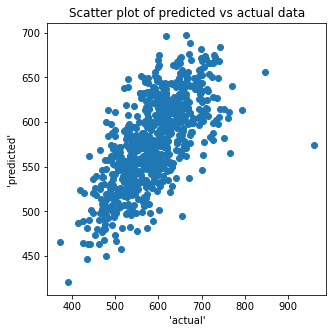

In [172]:
plt.figure(figsize=(5,5))
plt.scatter(x = y_test_rescaled, y = y_pred_rescaled)
plt.xlabel("'actual'")
plt.ylabel("'predicted'")
plt.title("Scatter plot of predicted vs actual data")

In [173]:
y_test_rescaled['time'] = y_test_rescaled.index
y_test_rescaled = y_test_rescaled.sort_values(by=['time'])
y_actual = pd.DataFrame(y_test_rescaled['y'])
y_actual.reset_index(drop=True, inplace=True)

y_pred_rescaled['time'] = y_test_rescaled.index
y_pred_rescaled = y_pred_rescaled.sort_values(by=['time'])
y_hat = pd.DataFrame(y_pred_rescaled['y'])
y_hat.reset_index(drop=True, inplace=True)

time = y_test_rescaled['time']

df.to_csv(r'res.csv', index = False)
y_test_rescaled.to_csv(r'ytest-combined.csv', index = False)
y_pred_rescaled.to_csv(r'ypred-combined.csv', index = False)

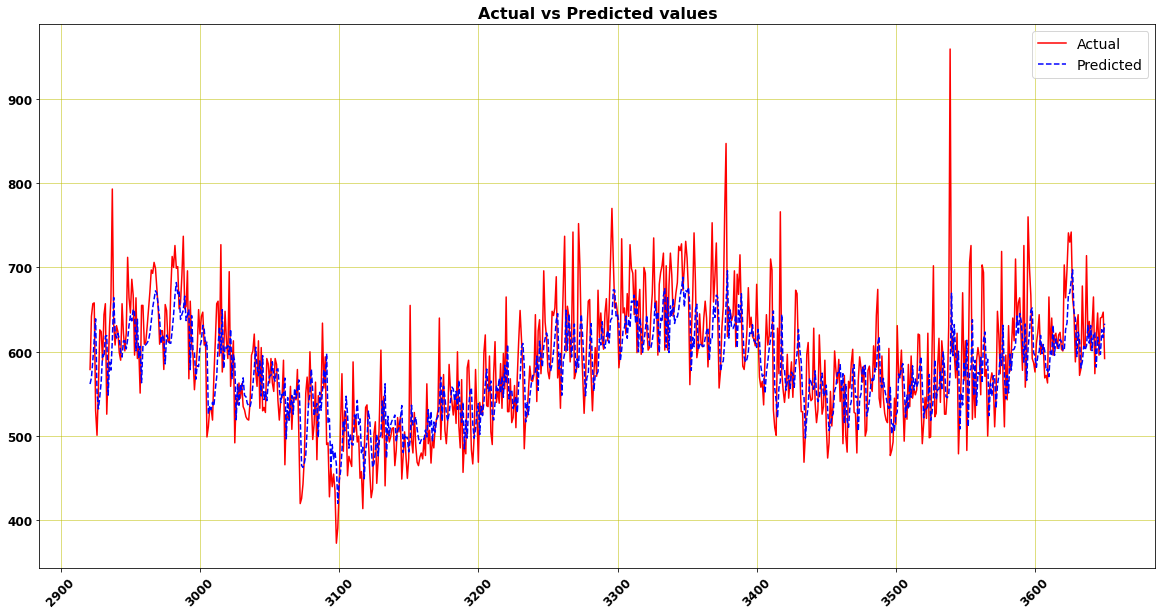

In [174]:
plt.figure(figsize=(20, 10))
plt.plot(time, y_actual, linestyle='solid', color='r')
plt.plot(time, y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('Actual vs Predicted values', weight='bold', fontsize=16)
#plt.ylabel('demand', weight='bold', fontsize=14)
#plt.xlabel('time', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()
